In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
from datetime import datetime
from types import SimpleNamespace

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import xarray
from dataset.dataset import ImageDataset, SingleImageDataset
from dataset.normalization import MinMax, ZeroMinMax
from dataset.station_dataset import GroundstationDataset
from lightning.pytorch import Trainer
from lightning.pytorch.loggers import WandbLogger
from models.ConvResNet_Jiang import ConvResNet
from models.LightningModule import LitEstimator, LitEstimatorPoint
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from utils.plotting import prediction_error_plot

# Config

In [7]:
## Set Up Model

ckpt_fn = "/scratch/snx3000/kschuurm/irradiance_estimation/train/SIS_point_estimation/ws24i0hm/checkpoints/epoch=31-step=5631.ckpt"

config = {
    "batch_size": 2048,
    "patch_size": {
        "x": 15,
        "y": 15,
        "stride_x": 1,
        "stride_y": 1,
    },
    "input_overlap": None,
    "x_vars": [
        "channel_1",
        "channel_2",
        "channel_3",
        "channel_4",
        "channel_5",
        "channel_6",
        "channel_7",
        "channel_8",
        "channel_9",
        "channel_10",
        "channel_11",
        "DEM",
    ],
    "y_vars": ["SIS"],
    "x_features": ["dayofyear", "lat", "lon", "SZA", "AZI"],
    "transform": ZeroMinMax(),
    "target_transform": ZeroMinMax(),
}
config = SimpleNamespace(**config)



# Trainer and Model

In [8]:
# estimator = LitEstimator()
trainer = Trainer(
    # profiler="simple",
    # num_sanity_val_steps=2,
    accelerator="gpu",
    devices=-1,
    precision="32",
)

model = ConvResNet(
    num_attr=len(config.x_features),
    input_channels=len(config.x_vars),
    output_channels=len(config.y_vars),
)

estimator = LitEstimatorPoint.load_from_checkpoint(
    ckpt_fn,
    learning_rate=0.001,
    model=model,
    config=config,
)

/scratch/snx3000/kschuurm/lightning/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /scratch/snx3000/kschuurm/lightning/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/scratch/snx3000/kschuurm/lightning/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


# Station dataset

In [ ]:
stations = ["CAB", "CAR", "CEN", "MIL", "NOR", "PAL", "PAY", "TAB", "TOR", "VIS"]

test_datasets = [
    GroundstationDataset(
        nm,
        config.y_vars,
        config.x_vars,
        config.x_features,
        patch_size=15,
        time_window=12,
        transform=config.transform,
        target_transform=config.target_transform,
    )
    for nm in stations
]

In [34]:
station_seviri.sizes

Frozen({'time': 222098, 'y': 31, 'x': 30})

In [33]:
station_seviri = xarray.open_zarr(f'/scratch/snx3000/kschuurm/ZARR/CAB/SEVIRI_CAB.zarr') \
                                    .drop_duplicates('time')
station_seviri.rename({'y':'lat','x':'lon'}).isel(time=[0,1]).to_dataarray(dim='channels')

<xarray.DataArray (channels: 12, time: 2, lat: 31, lon: 30)>
dask.array<stack, shape=(12, 2, 31, 30), dtype=float64, chunksize=(1, 2, 31, 30), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 2016-01-01 2016-01-01T00:15:00
  * lon       (lon) float64 4.175 4.225 4.275 4.325 ... 5.475 5.525 5.575 5.625
  * lat       (lat) float64 51.23 51.28 51.33 51.38 ... 52.58 52.62 52.68 52.73
  * channels  (channels) object 'IR_016' 'IR_039' ... 'WV_073' 'spatial_ref'

In [ ]:
time = ds.rolling_station.time

In [ ]:
ds.rolling_station.SIS.plot.hist()

In [66]:
solarpos = xarray.open_zarr("/scratch/snx3000/kschuurm/ZARR/SOLARPOS.zarr").drop_duplicates(dim="time")

AZI = solarpos.sel(lat=51.97, lon=4.927, method='nearest').sel(time=time).AZI.load()
AZI_station = ds.rolling_station.AZI.load()

In [ ]:
plt.scatter(AZI, AZI_station, s=0.1)
plt.xlabel('AZI calculated')
plt.ylabel('AZI from station dataset')

In [ ]:
SZA = solarpos.sel(lat=51.97, lon=4.927, method='nearest').sel(time=time).SZA.load()
SZA_station = ds.rolling_station.SZA.load()

plt.scatter(SZA, SZA_station, s=0.1)
plt.xlabel('AZI calculated')
plt.ylabel('AZI from station dataset')

In [17]:
predictions_stations = [trainer.predict(estimator, DataLoader(ds, 400000, shuffle=False)) for ds in test_datasets]

predictions_stations = { nm: {'y_hat': torch.cat([p[0] for p in pred]),
                              'y': torch.cat([p[1] for p in pred]),
                              'x': torch.cat([p[2] for p in pred]) } for nm, pred in zip(stations, predictions_stations)}

/scratch/snx3000/kschuurm/lightning/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /scratch/snx3000/kschuurm/lightning/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/scratch/snx3000/kschuurm/lightning/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

CAB: 	 mean error: 30 std error: 90
CAR: 	 mean error: 11 std error: 86
CEN: 	 mean error: 10 std error: 94
MIL: 	 mean error: 36 std error: 88
NOR: 	 mean error: 18 std error: 77
PAL: 	 mean error: 26 std error: 93
PAY: 	 mean error: 10 std error: 96
TAB: 	 mean error: 8 std error: 93
TOR: 	 mean error: 8 std error: 84
VIS: 	 mean error: 8 std error: 142


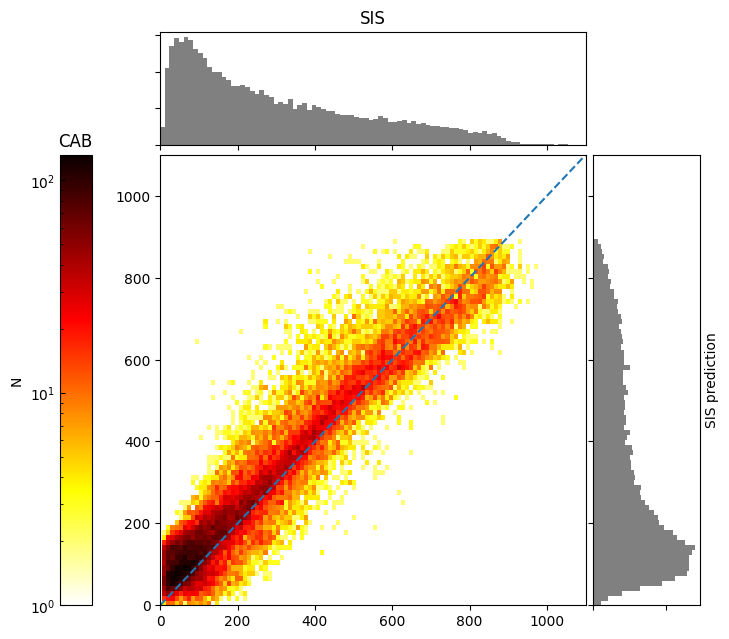

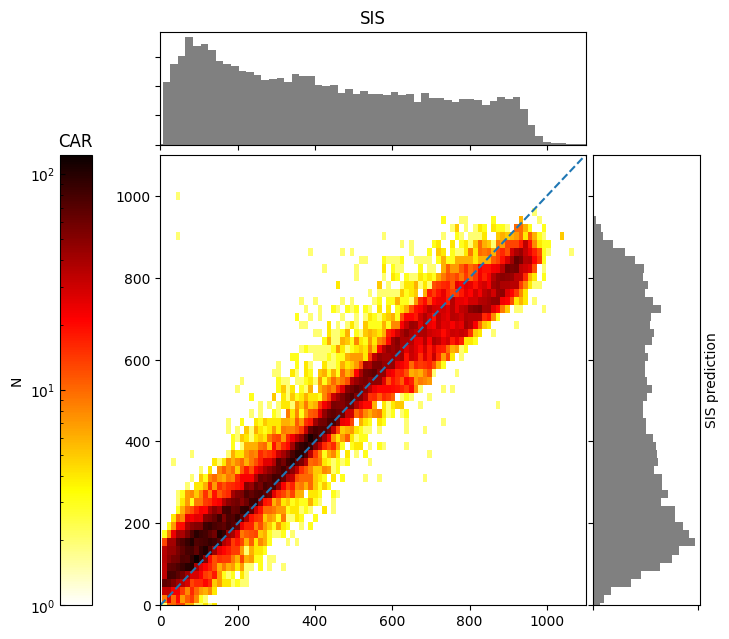

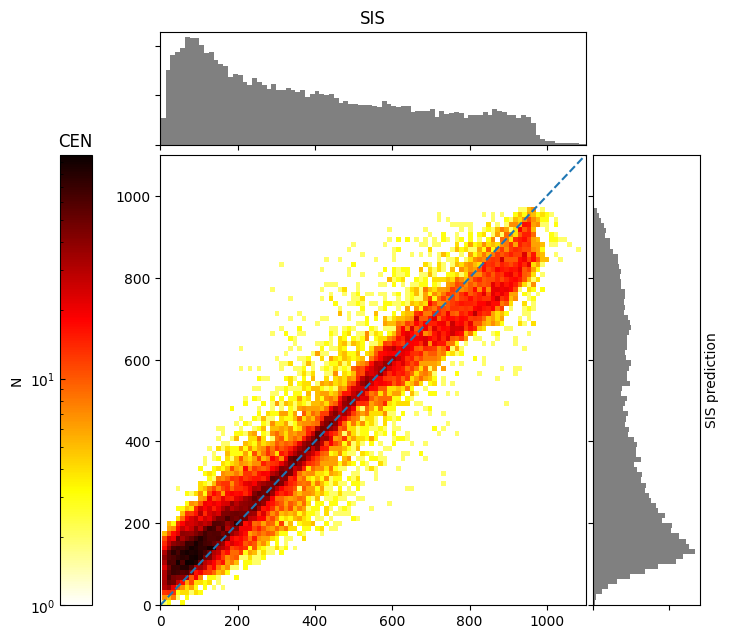

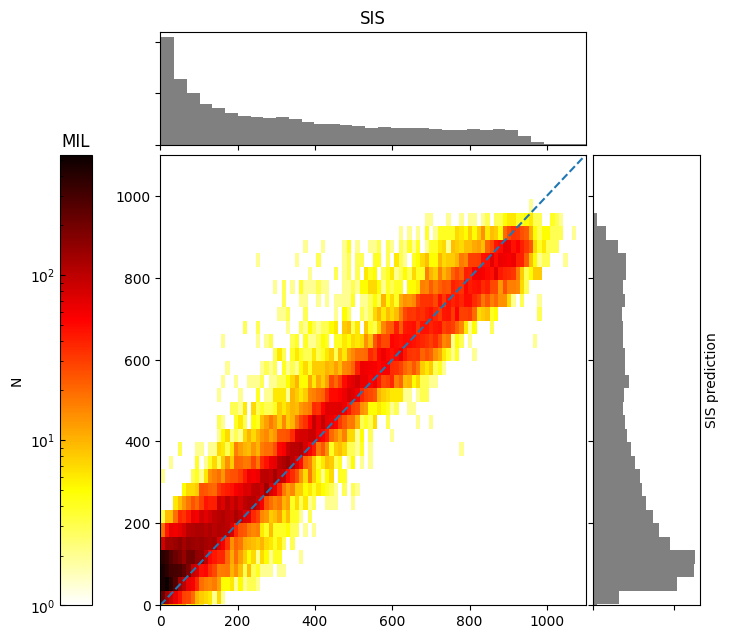

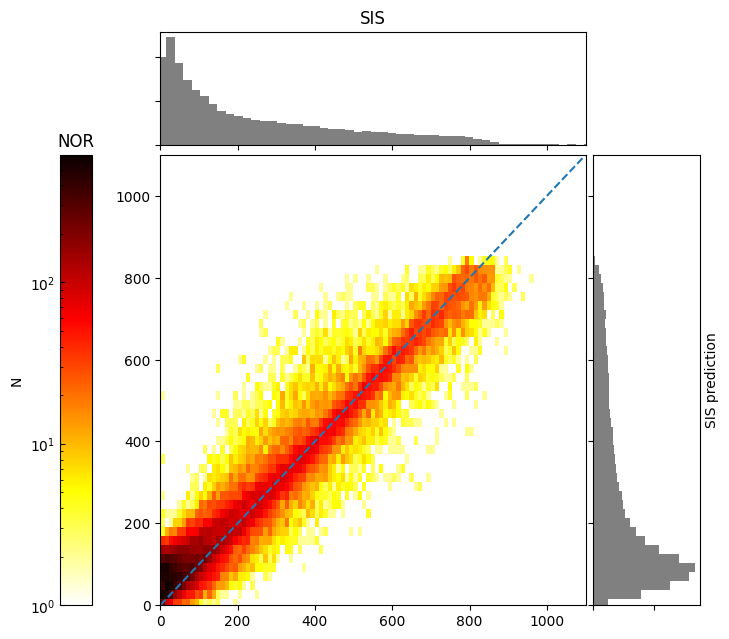

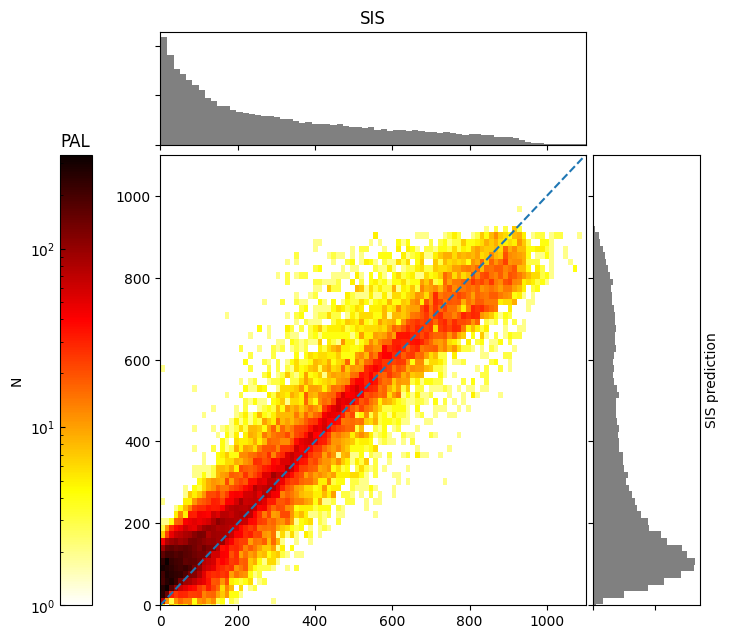

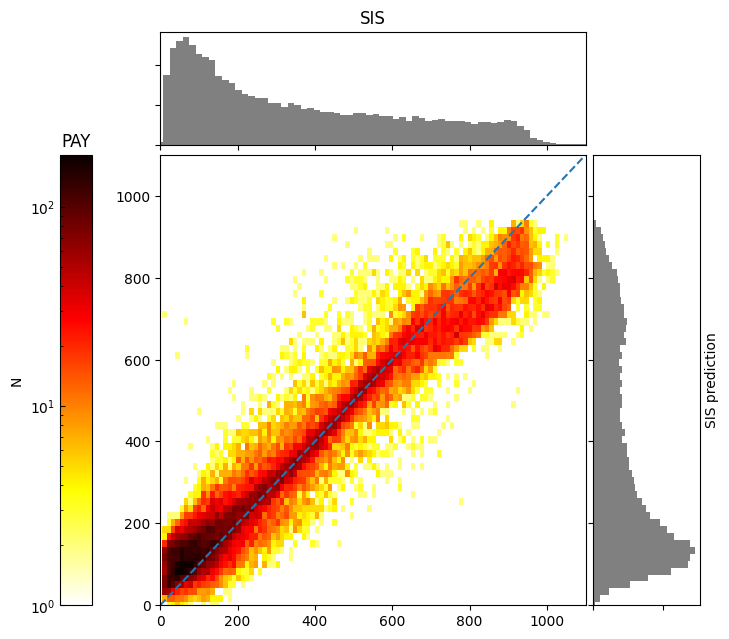

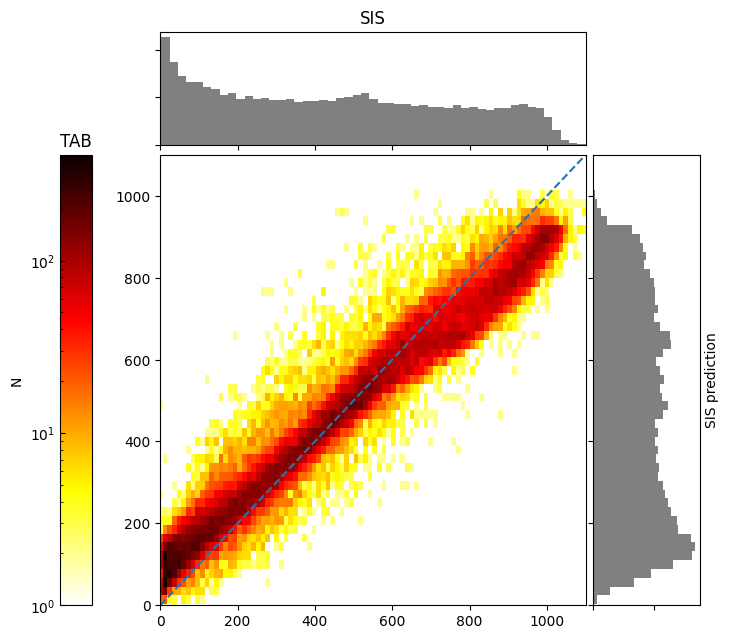

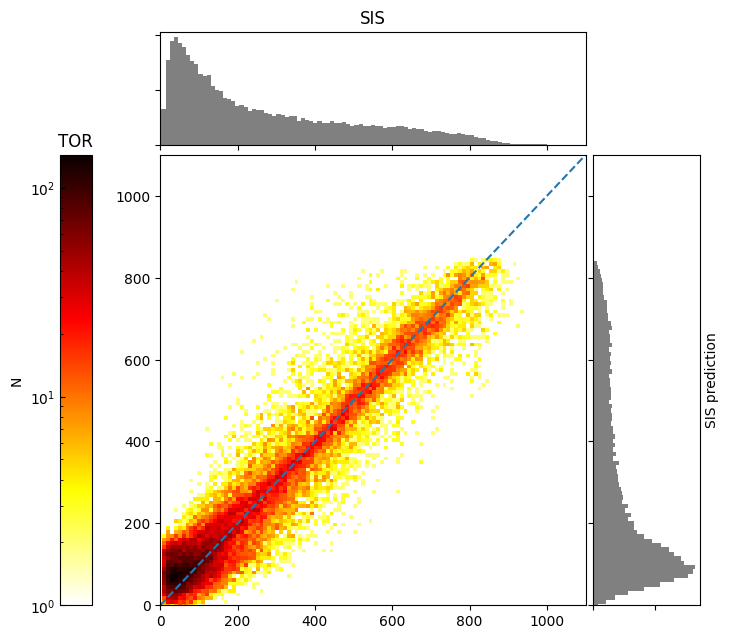

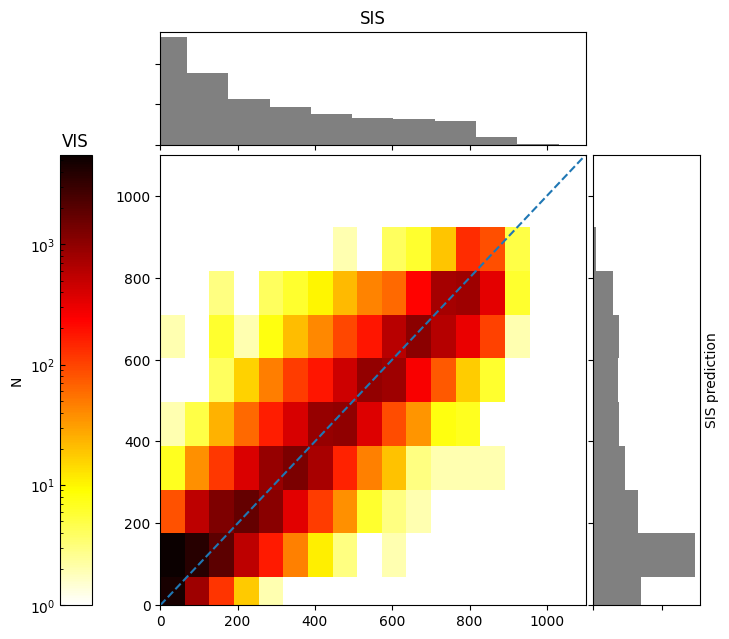

In [18]:
def statistics_stations(predictions_stations):
    for key, val in predictions_stations.items():
        y_hat = config.transform.inverse(val['y_hat'].cpu(), ['SIS'])
        y = config.transform.inverse(val['y'].cpu(), ['SIS'])
        error = y_hat - y
        # error = config.transform.inverse(error.squeeze().cpu(), ["SIS"])
        mean = torch.nanmean(error).item()
        std = torch.std(error).item()
        print(f"{key}: \t mean error: {round(mean)} std error: {round(std)}")
        prediction_error_plot(y, y_hat, title=key)
    
statistics_stations(predictions_stations)

NameError: name 'time' is not defined

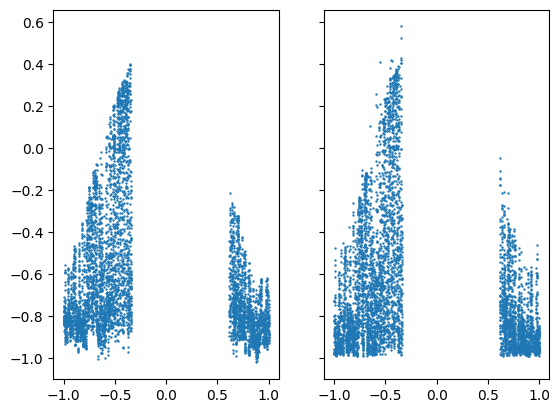

In [19]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, sharex=True)

i = 0
j = slice(-10000,-5000)
ax1.scatter(predictions_stations['CAB']['x'][j,i], predictions_stations['CAB']['y_hat'][j], s=.5)
ax2.scatter(predictions_stations['CAB']['x'][j,i], predictions_stations['CAB']['y'][j], s=.5)
print(time[j].dt.hour)
print(time[j].dt.day)

# Full image comparison

In [20]:
imageDataset = ImageDataset(
    x_vars=config.x_vars,
    y_vars=config.y_vars,
    x_features=config.x_features,
    patch_size=config.patch_size,
    transform=config.transform,
    target_transform=config.target_transform,
    random_sample=None,
    batch_in_time=None,
    dtype=torch.float32,
)

dts = imageDataset.images

In [21]:
dataset = imageDataset.load_singleImageDataset_generator(dt=dts[4000]).result()

In [22]:
dataloader = DataLoader(dataset, batch_size=10000, num_workers=1)
predictions = trainer.predict(estimator, dataloader)

/scratch/snx3000/kschuurm/lightning/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /scratch/snx3000/kschuurm/lightning/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/scratch/snx3000/kschuurm/lightning/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [23]:
def predictions_to_image(predictions, input_image, config, patch_size):

    y_hat = torch.cat([x[0] for x in predictions]).squeeze()
    y = torch.cat([x[1] for x in predictions]).squeeze()
    lat = torch.cat([x[2][:, 1] for x in predictions])
    lon = torch.cat([x[2][:, 2] for x in predictions])

    img_dim = (len(input_image.lon) - config.patch_size['x'] +1,
               len(input_image.lat) - config.patch_size['y'] +1,)
    
    y_hat = y_hat.reshape(img_dim)
    y = y.reshape(img_dim)
    lat = lat.reshape(img_dim)
    lon = lon.reshape(img_dim)

    y_hat = config.target_transform.inverse(y_hat, ["SIS"])
    y = config.target_transform.inverse(y, ["SIS"])
    lat = config.transform.inverse(lat, ["lat"])
    lon = config.transform.inverse(lon, ["lon"])

    output_image = xarray.DataArray(
        data=y_hat.T,
        # dims=('x','y'),
        coords={"lat": (('lat'), lat[0, :]),
                "lon": (('lon'), lon[:, 0]),},
        attrs=input_image.SIS.attrs,
    )

    output_image.lat.attrs = input_image.lat.attrs
    output_image.lon.attrs = input_image.lon.attrs
    return output_image, y, y_hat


def image_1d_to_2d(arr, dim, patch_size):
    return arr.reshape(
        dim[0] - patch_size["y"] + 1,
        dim[1] - patch_size["x"] + 1,
    )

In [24]:
output_image, y, y_hat = predictions_to_image(
    predictions, dataset.sarah, config, config.patch_size
)

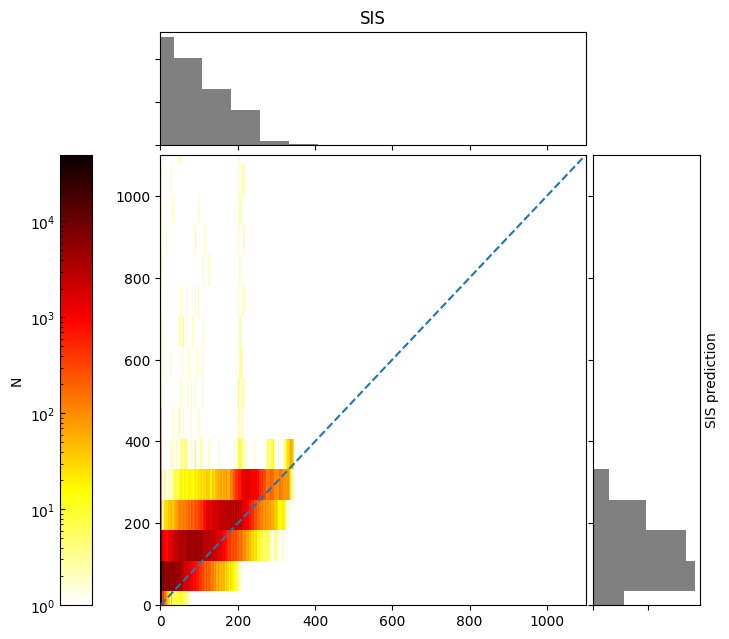

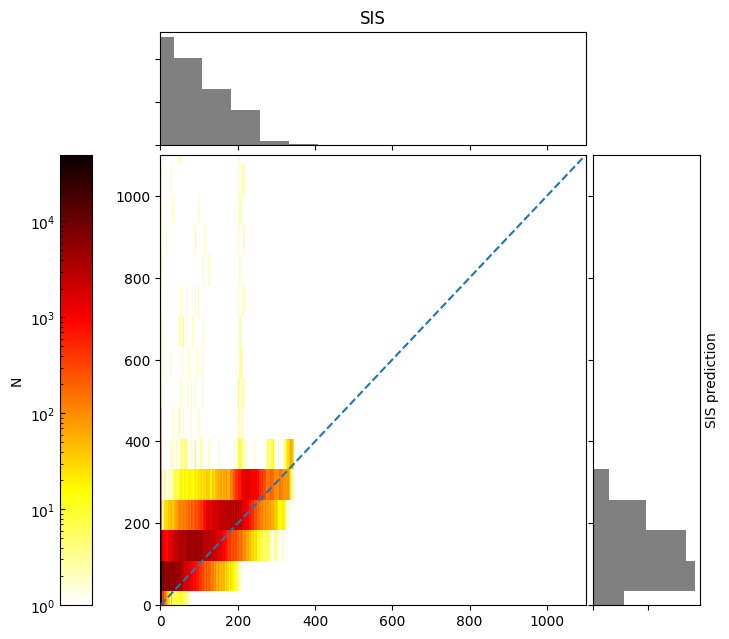

In [30]:
prediction_error_plot(y.flatten(), y_hat.flatten())

Text(0.5, 1.0, 'DL estimator')

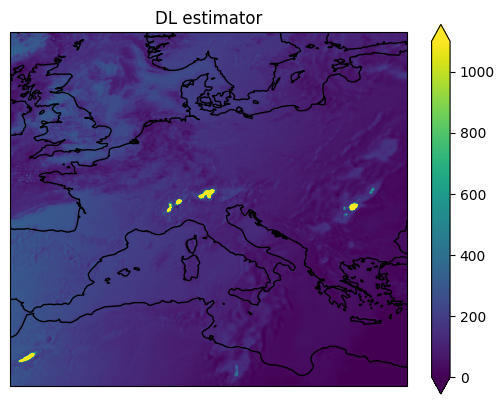

In [26]:
ax = plt.subplot(projection=ccrs.PlateCarree())
ax.coastlines()
output_image.plot.imshow(vmin=0, vmax=1100, ax=ax)
plt.title("DL estimator")
# plt.text(0.5, 0.05, str(input_image.time))

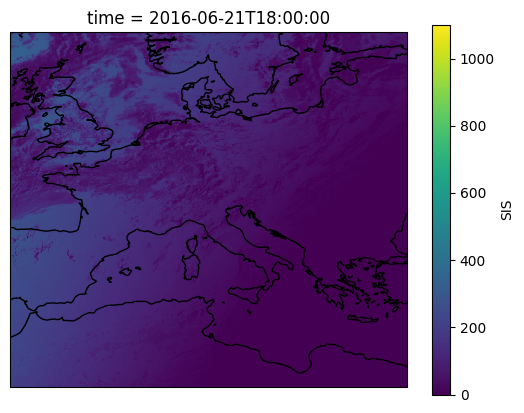

In [27]:
ax = plt.subplot(projection=ccrs.PlateCarree())
ax.coastlines()
dataset.sarah.isel(time=0).SIS.plot.imshow(vmin=0, vmax=1100, ax=ax)
# plt.title("SARAH-3")

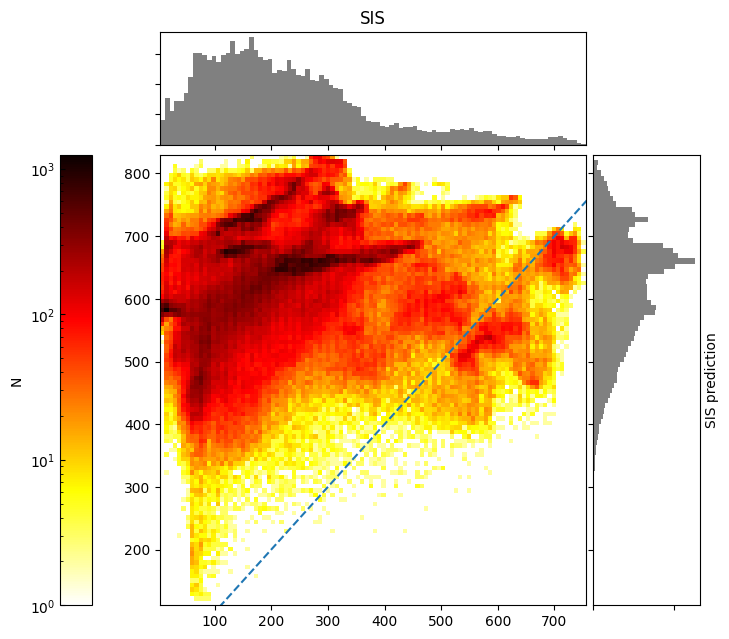

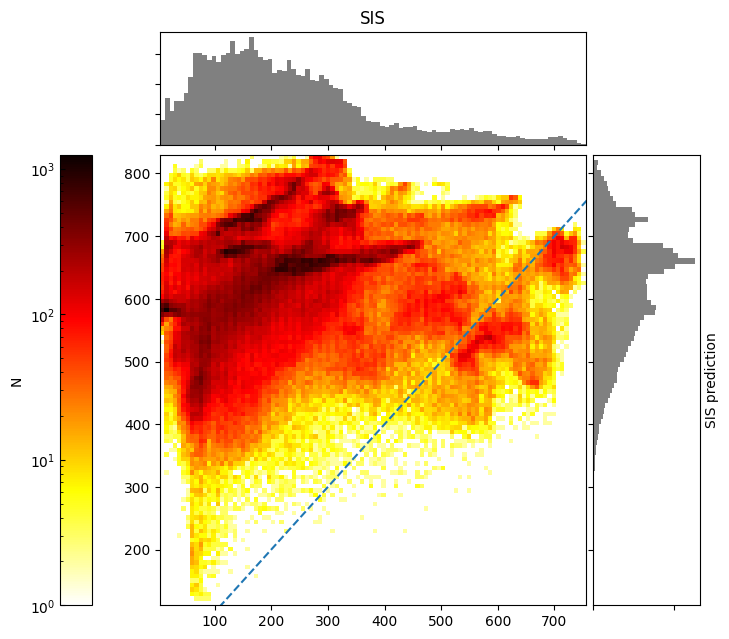

In [28]:
error = output_image - dataset.sarah.SIS.reindex_like(output_image, method="nearest")

ValueError: A 3-dimensional array was passed to imshow(), but there is no dimension that could be color.  At least one dimension must be of size 3 (RGB) or 4 (RGBA), and not given as x or y.

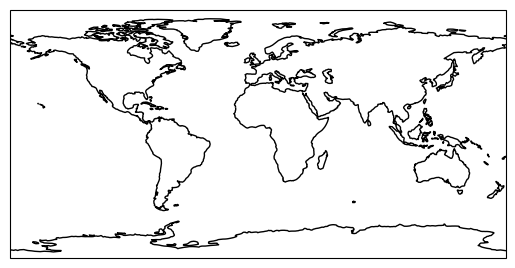

In [29]:
ax = plt.subplot(projection=ccrs.PlateCarree())
ax.coastlines()
error.plot.imshow(ax=ax)